In [43]:

import os
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, skew
import statsmodels
import numpy as np
from sklearn import metrics

In [44]:
def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i]).pvalue} \n\n'))


def compute_auc(array_1, array_2):
    xs = np.concatenate([array_1, array_2],axis=1)
    y = np.concatenate([array_1.shape[1]*[2], array_2.shape[1]*[1]])
    
    for i, x in enumerate(xs):
        fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=2)
        #print(i, metrics.auc(fpr, tpr))
        m = metrics.roc_auc_score(y, x)
        print(round(max(m, 1-m), 2))


def compute_eta_squared(H, n_of_grp,n_of_observ):
    return (H - n_of_grp + 1)/(n_of_observ - n_of_grp)

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
    return list_object

def holm_correction(kruskal):
    line_to_remove=[]
    values=[]
    corrected =[]
    final = []
    for l in kruskal:
        if "nan" in l:
            line_to_remove.append(kruskal.index(l))
    
    new_krusk = delete_multiple_element(kruskal, line_to_remove)
            
    for line in new_krusk:
        ok = line.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(float(num))
   # values = [x for x in values if isnan(x) == False]
    result = statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)
    num = np.where(result[0] == True)
    list_index = ((num)[0]).tolist()

    for i in list_index:
        corrected.append(result[1][i])
    for i in list_index:
        final.append(kruskal[i])
    
    return final, corrected
    

In [45]:
def read_stats_test(file):
    
    with open(file, 'r') as f:
        lista = []
        testo = f.readlines()
        testo = [line.strip("\n") for line in testo]

        for line in testo:
            if line=="":
                pass
            else:
                lista.append(line)
                
    return lista

In [46]:
def compute_best_scores(lista):    

    values = []
    critical = []
    final = [] 
    
    for l in lista:
        ok = l.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(num)

    for value in values:
        if float(value) < 0.05:
            critical.append(value)

    for li in lista:
        for cri in critical:
            if cri in li:
                final.append(li)

    return final

In [47]:
path ='/export/b15/afavaro/Frontiers/NLS/Alignment/'
tot_PATH = [os.path.join(path, base) for base in os.listdir(path)]

In [48]:
list_of_dataframes = []

for element in tot_PATH:
    participant = pd.read_csv(element)
    elem = os.path.basename(element)
    #name = elem.split(".csv")[0]
    name = elem.split("_ses")[0]
    total_name = elem.split(".")[0]
    task = (elem.split("_", 3)[3].split(".csv")[0])
    
    tot= participant.time_stamp.tolist()
    tot = (list(set(tot)))
    unique = participant['time_stamp'].unique()
    stdx = unique.std()
    kurtx = kurtosis(unique)
    skewx =  skew(unique)

    # Compute standard deviation, skewness and kurtosis of the initial timestamp of each word in each recording.

    dict = {'name': name, 'total_name': total_name, 'tasks': task,'rhythm_std': stdx,'rhythm_skew': skewx, 'rhythm_kurt': kurtx} # 'Rhythm_kurt': kurtosis, 
    df = pd.DataFrame(dict, index=[0])
    list_of_dataframes.append(df)

data_ = pd.concat(list_of_dataframes, ignore_index=True)
data_ = data_.dropna()

In [51]:
# Add labels to the data frame

label_seneca = pd.read_excel("/export/b14/afavaro/Acoustic_Features/DigiPsych_Prosody/Hospital_Analysis/Book3.xlsx")
label = label_seneca['Label'].tolist()
speak = label_seneca['Participant I.D.'].tolist() #id
spk2lab_ = {sp:lab for sp,lab in zip(speak,label)}
speak2__ = data_['name'].tolist()
etichettex = []
for nome in speak2__:
    if nome in spk2lab_.keys():
        lav = spk2lab_[nome]
        etichettex.append(([nome, lav]))
    else:
         etichettex.append(([nome, 'Unknown']))
label_new_ = []
for e in etichettex:
    label_new_.append(e[1])
data_['label'] = label_new_
label = label_seneca['Age'].tolist()
speak = label_seneca['Participant I.D.'].tolist()
spk2lab_ = {sp:lab for sp,lab in zip(speak,label)}
speak2__ = data_['name'].tolist()
etichettex = []
for nome in speak2__:
    if nome in spk2lab_.keys():
        lav = spk2lab_[nome]
        etichettex.append(([nome, lav]))
    else:
         etichettex.append(([nome, 'Unknown']))
label_new_ = []
for e in etichettex:
    label_new_.append(e[1])
data_['age'] = label_new_
#%

# Group the data frame task=wise to perform the analysis.
tot = data_.groupby('tasks')
rp = tot.get_group('RainbowPassage')
ctp = tot.get_group('CookieThief')
jk =  tot.get_group('Joke')
pom = tot.get_group('Poem')

,name,total_name,tasks,rhythm_std,rhythm_skew,rhythm_kurt,label,age
0,AD_2,AD_2_ses1_Joke,Joke,9.617016,0.021698,-1.237440,CTRL,68.0
1,AD_2,AD_2_ses1_Poem,Poem,11.338126,0.106061,-1.234291,CTRL,68.0
2,AD_2,AD_2_ses1_RainbowPassage,RainbowPassage,21.023320,0.041398,-1.124490,CTRL,68.0
3,AD_2,AD_2_ses3_CookieThief,CookieThief,16.946362,0.109222,-1.124140,CTRL,68.0
4,AD_2,AD_2_ses3_Poem,Poem,11.173513,0.117271,-1.320821,CTRL,68.0
...,...,...,...,...,...,...,...,...
324,PEC_7,PEC_7_ses1_CookieThief,CookieThief,16.715641,0.019436,-1.124522,CTRL,64.0
325,PEC_7,PEC_7_ses1_Joke,Joke,10.030920,-0.034869,-1.078050,CTRL,64.0
326,PEC_7,PEC_7_ses1_Poem,Poem,9.016390,0.040262,-1.294648,CTRL,64.0
327,PEC_7,PEC_7_ses1_RainbowPassage,RainbowPassage,17.685135,0.150450,-1.364670,CTRL,64.0


## Rainbow passage (read passage)

In [68]:
grouped = rp.groupby("label") #here we extract the values by category
control = grouped.get_group("CTRL") 
control = control[~control.name.str.contains("PEC_4")]
control = control[~control.name.str.contains("PEC_5")]
control = control[~control.name.str.contains("PEC_9")]
control = control[~control.name.str.contains("PEC_14")]
control = control[~control.name.str.contains("PEC_15")]
control = control[~control.name.str.contains("PEC_16")]
control = control[~control.name.str.contains("PEC_17")]
control = control[~control.name.str.contains("PEC_18")]
control = control[~control.name.str.contains("PEC_19")]
control = control[~control.name.str.contains("PEC_23")]
ontrol = control[~control.name.str.contains("PEC_25")]
control = control[~control.name.str.contains("PEC_29")]
control = control[~control.name.str.contains("PEC_35")] 
parkinson_ = grouped.get_group("PD")
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_116")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_34")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_35")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_33")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_21")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_20")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]
#

task = rp.columns[3:-4].values.tolist()
parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(rp.columns[3:-4])])
control_all_feat = np.array([control[feat] for feat in np.array(rp.columns[3:-4])])

with open('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/RP_RHYTHM_RT.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")

kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/RP_RHYTHM_RT.txt')
holm_correction(kruskal_1)

([], [])

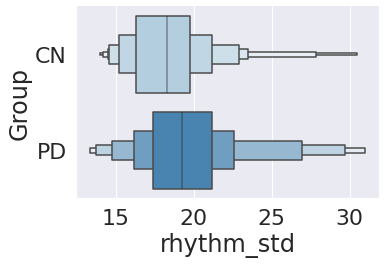

In [69]:
for i, title in enumerate(task):
    nome = title
    controls = []
    parkinson=[]
    
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)

    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)

## Cookie Theft picture description (spontaneous production)

In [73]:
grouped = ctp.groupby("label") #here we extract the values by category
control = grouped.get_group("CTRL") 
control = control[~control.name.str.contains("PEC_4")]
control = control[~control.name.str.contains("PEC_5")]
control = control[~control.name.str.contains("PEC_9")]
control = control[~control.name.str.contains("PEC_14")]
control = control[~control.name.str.contains("PEC_15")]
control = control[~control.name.str.contains("PEC_16")]
control = control[~control.name.str.contains("PEC_17")]
control = control[~control.name.str.contains("PEC_18")]
control = control[~control.name.str.contains("PEC_19")]
control = control[~control.name.str.contains("PEC_23")]
control = control[~control.name.str.contains("PEC_25")]
control = control[~control.name.str.contains("PEC_29")]
control = control[~control.name.str.contains("PEC_35")]

parkinson_ = grouped.get_group("PD")

parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_116")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_34")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_35")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_33")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_21")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_20")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]

task = ctp.columns[3:-4].values.tolist()

parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(ctp.columns[3:-4])])
control_all_feat = np.array([control[feat] for feat in np.array(ctp.columns[3:-4])])

with open('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/ctp_RHYTHM_RT.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")

kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/ctp_RHYTHM_RT.txt')
holm_correction(kruskal_1)

(['kruskal results for rhythm_std controls vs. parkinson 0.032046086123234854 '],
 [0.032046086123234854])

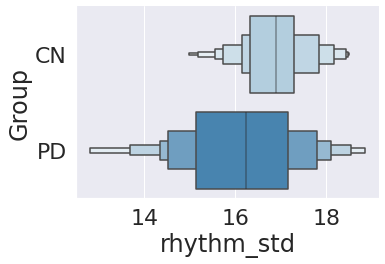

In [74]:
for i, title in enumerate(task):  
    
    nome = title
    controls = []
    parkinson=[]
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    data = [float(x) for x in data if x != "None"]
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)

## Poem (Read passage)

In [77]:
grouped = pom.groupby("label") #here we extract the values by category
control = grouped.get_group("CTRL") 
control = control[~control.name.str.contains("PEC_4")]
control = control[~control.name.str.contains("PEC_5")]
control = control[~control.name.str.contains("PEC_9")]
control = control[~control.name.str.contains("PEC_14")]
control = control[~control.name.str.contains("PEC_15")]
control = control[~control.name.str.contains("PEC_16")]
control = control[~control.name.str.contains("PEC_17")]
control = control[~control.name.str.contains("PEC_18")]
control = control[~control.name.str.contains("PEC_19")]
control = control[~control.name.str.contains("PEC_23")]
control = control[~control.name.str.contains("PEC_25")]
control = control[~control.name.str.contains("PEC_29")]
control = control[~control.name.str.contains("PEC_35")]
parkinson_ = grouped.get_group("PD")

parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_116")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_34")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_35")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_33")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_21")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_20")]
parkinson_ = parkinson_[~parkinson_.name.str.contains("NLS_12")]

task = pom.columns[3:-4].values.tolist()

parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(pom.columns[3:-4])])
control_all_feat = np.array([control[feat] for feat in np.array(pom.columns[3:-4])])


with open('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/pom_RHYTHM_RT.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")

kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/NLS/COGNITIVE/Results/pom_RHYTHM_RT.txt')
holm_correction(kruskal_1)

(['kruskal results for rhythm_std controls vs. parkinson 0.02802091023579375 '],
 [0.02802091023579375])

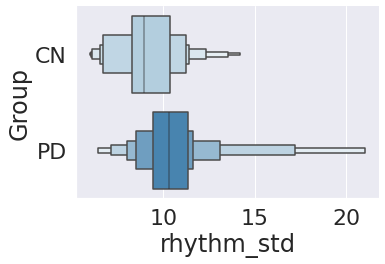

In [76]:
for i, title in enumerate(task):  
    
    nome = title
    controls = []
    parkinson=[]
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    data = [float(x) for x in data if x != "None"]
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
